In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping


2025-08-07 16:59:30.279476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754566170.315625    3880 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754566170.326015    3880 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754566170.373858    3880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754566170.373924    3880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754566170.373926    3880 computation_placer.cc:177] computation placer alr

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

base_dir = "./data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


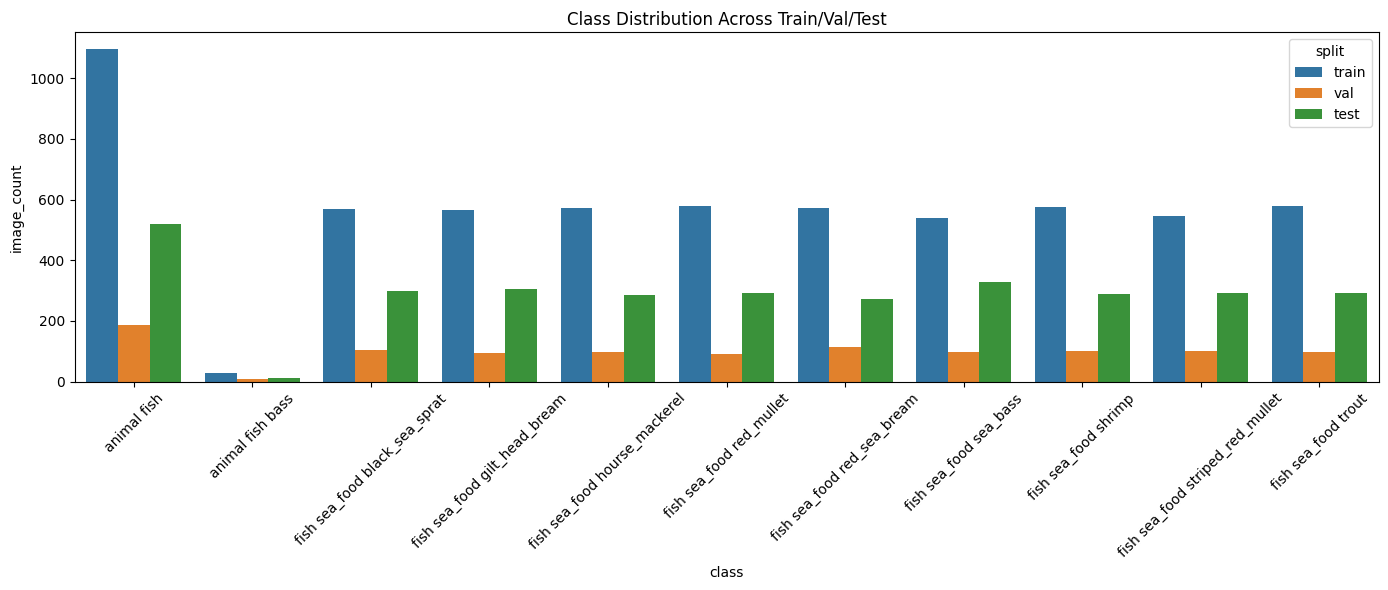

In [3]:
splits = ['train', 'val', 'test']
distribution = []

for split in splits:
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path) 
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            distribution.append({
                'split': split,
                'class': class_name,
                'image_count': num_images
            })

df_dist = pd.DataFrame(distribution)

# Plot class distribution
plt.figure(figsize=(14, 6))
sns.barplot(data=df_dist, x='class', y='image_count', hue='split')
plt.title("Class Distribution Across Train/Val/Test")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

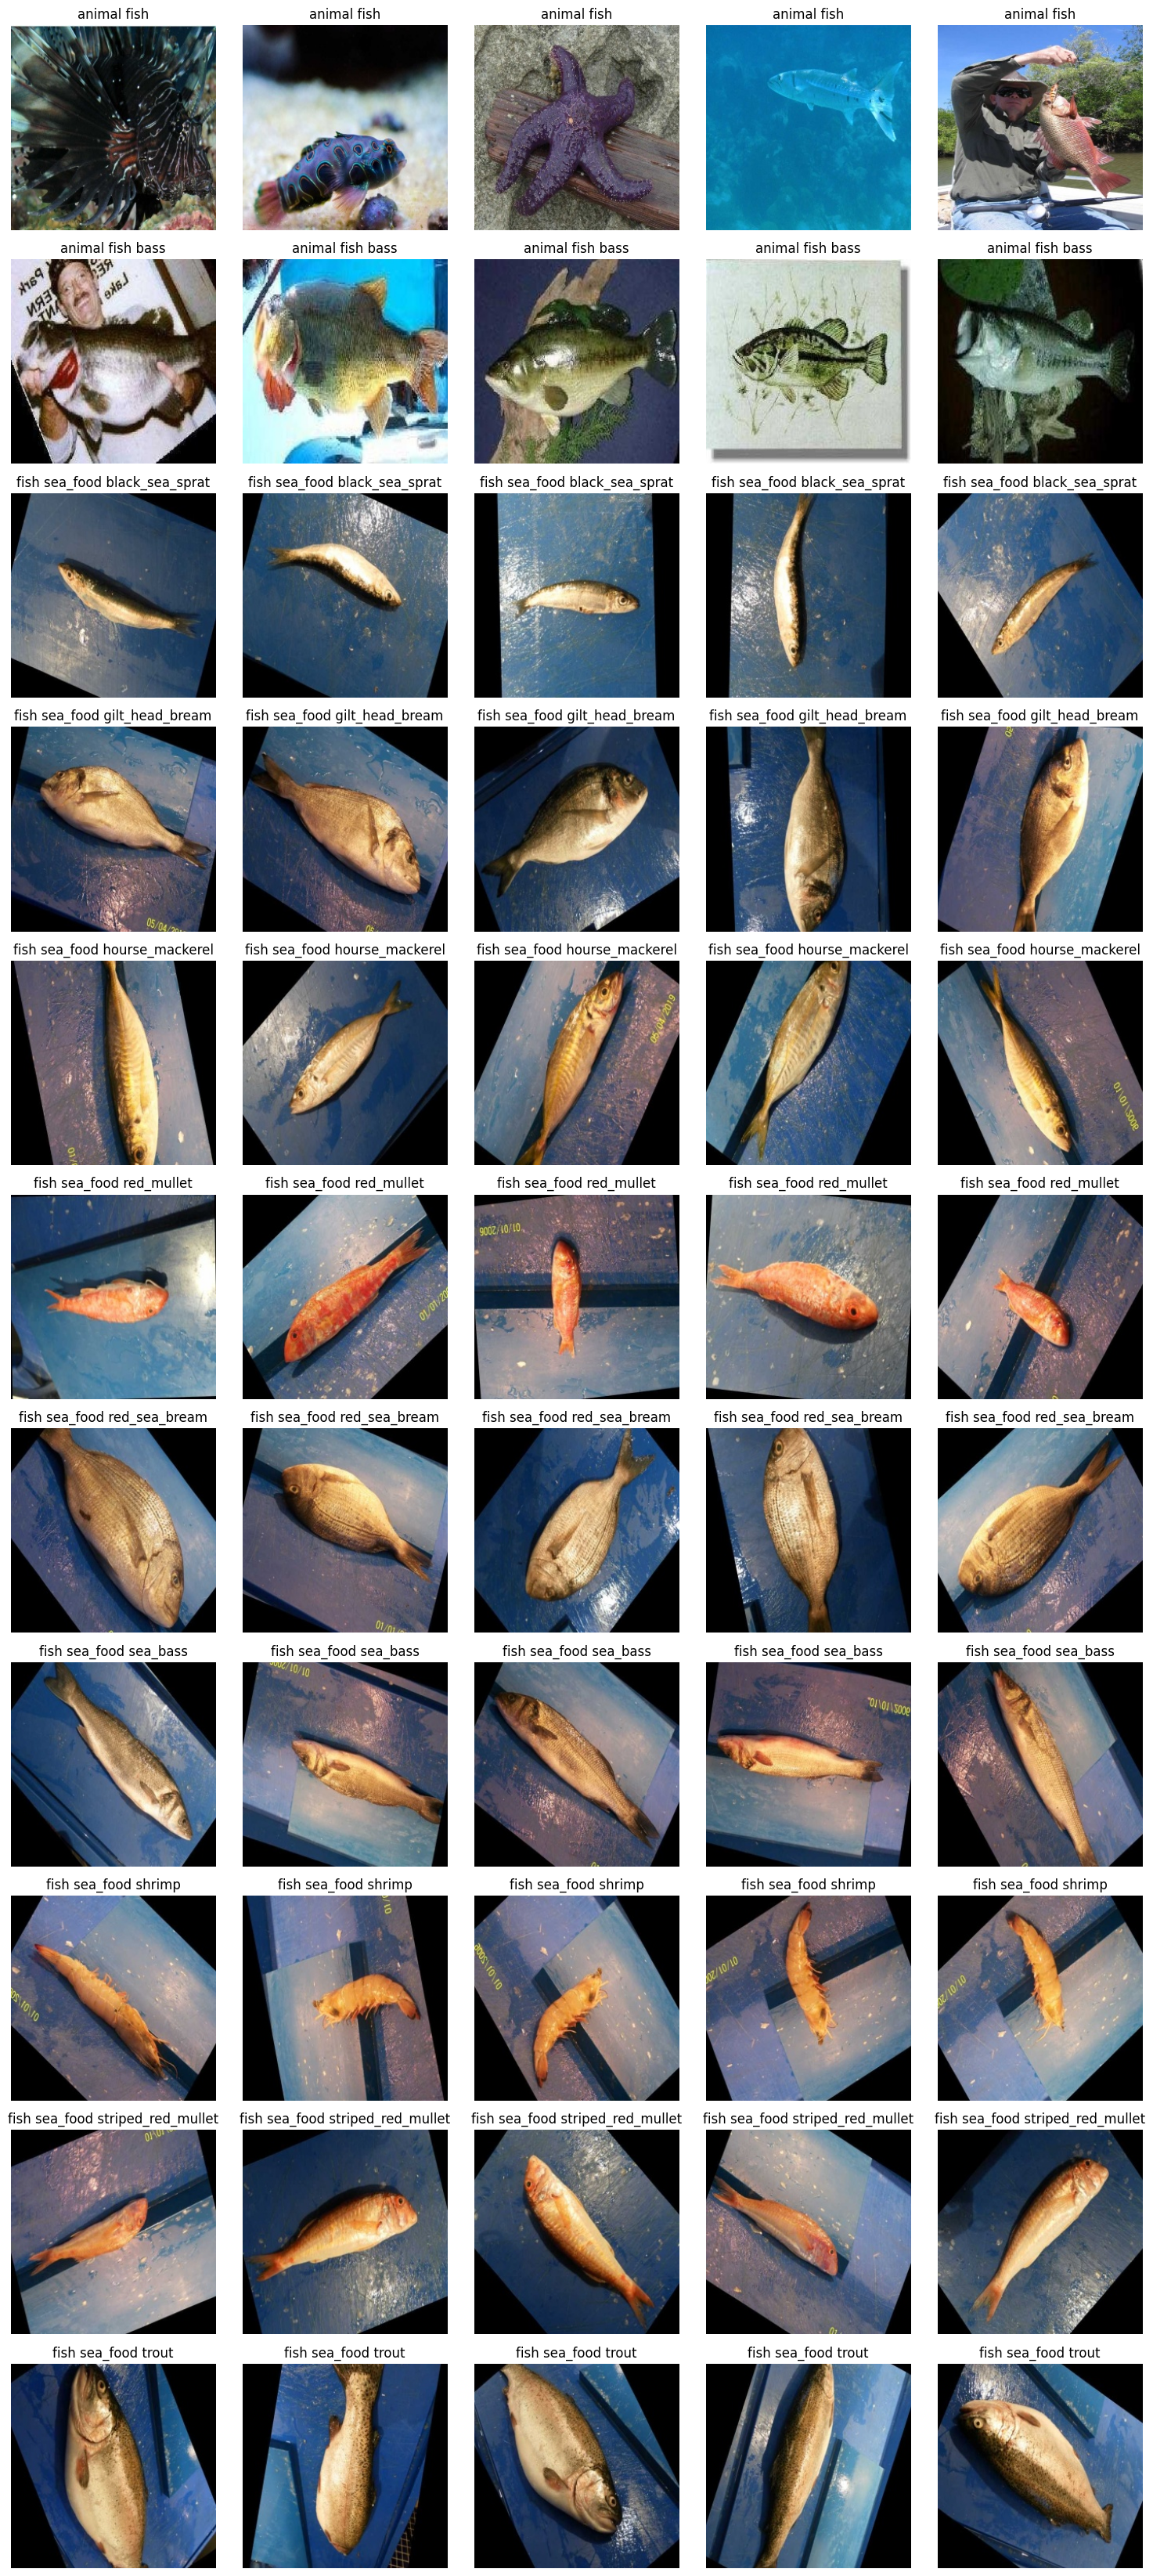

In [4]:
import matplotlib.image as mpimg
import random

def show_sample_images(base_dir, split='train', n=5):
    split_path = os.path.join(base_dir, split)
    class_dirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    
    plt.figure(figsize=(15, 3 * len(class_dirs)))
    img_index = 1
    for class_name in sorted(class_dirs):
        class_path = os.path.join(split_path, class_name)
        sample_files = random.sample([
            f for f in os.listdir(class_path) 
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ], min(n, len(os.listdir(class_path))))
        
        for file in sample_files:
            img = mpimg.imread(os.path.join(class_path, file))
            plt.subplot(len(class_dirs), n, img_index)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
            img_index += 1

    plt.tight_layout()
    plt.show()

# Show 5 images per class from train set
show_sample_images(base_dir, split='train', n=5)


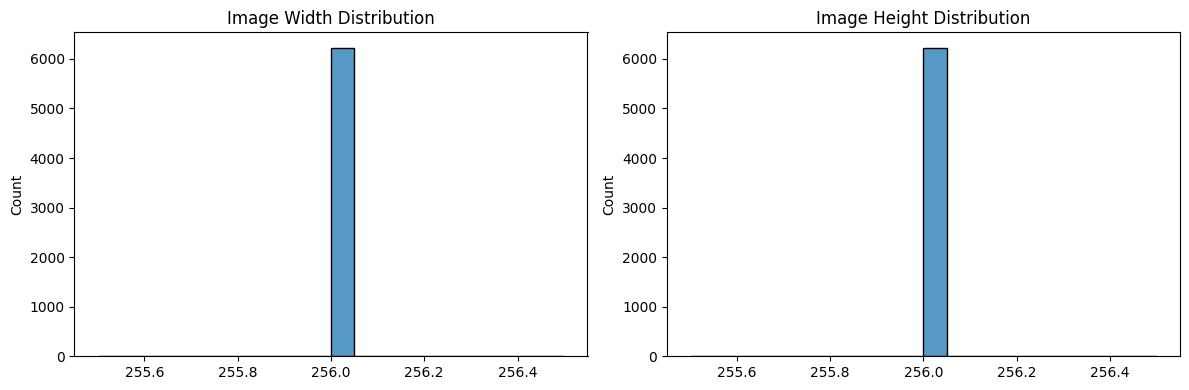

Average Image Size: 256.0 x 256.0


In [5]:
from PIL import Image
import numpy as np

def get_image_shapes(base_dir, split='train'):
    shapes = []
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                try:
                    img_path = os.path.join(class_path, file)
                    with Image.open(img_path) as img:
                        shapes.append(img.size)  # (width, height)
                except:
                    continue
    return shapes

# Analyze shapes in train set
shapes = get_image_shapes(base_dir, 'train')
widths, heights = zip(*shapes)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20)
plt.title("Image Width Distribution")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20)
plt.title("Image Height Distribution")

plt.tight_layout()
plt.show()

print(f"Average Image Size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_data = test_val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_val_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

class_names = list(train_data.class_indices.keys())
num_classes = len(class_names)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [7]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.savefig(f"plots/{model_name}_history.png")
    plt.show()


In [8]:
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model



In [9]:
cnn_model = build_custom_cnn()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



/home/tanuj/jupyter_project/mybase/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754566196.687743    3880 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history_cnn = cnn_model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stop])



/home/tanuj/jupyter_project/mybase/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1754566200.142859    4033 service.cc:152] XLA service 0x7fb010004d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754566200.142926    4033 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-07 17:00:00.176994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754566200.435704    4033 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-07 17:00:01.134215: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.6 = (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.4260, f32[32,3,3,3]{3,2,1,0} %bitcast.4267, f32[32]{0} %bitcast.4705), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$con

  2/195 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.0938 - loss: 5.8611

I0000 00:00:1754566206.009312    4033 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 63/195 ━━━━━━━━━━━━━━━━━━━━ 47s 359ms/step - accuracy: 0.1741 - loss: 4.0330

2025-08-07 17:00:29.094689: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.6 = (f32[17,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[17,3,224,224]{3,2,1,0} %bitcast.4260, f32[32,3,3,3]{3,2,1,0} %bitcast.4267, f32[32]{0} %bitcast.4705), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/tanuj/jupyter_project/mybase/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-08-07 17:00:29.270652: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted po

157/195 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step - accuracy: 0.2257 - loss: 3.0485

In [ ]:
cnn_model.save("models/custom_cnn_model.h5")
plot_history(history_cnn, "Custom_CNN")


In [ ]:
loss, accuracy = cnn_model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {accuracy*100:.2f}%")

In [ ]:
def build_transfer_model(base_model, preprocess_input_fn, name):
    base = base_model(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base.trainable = False

    model = Sequential([
        tf.keras.layers.Lambda(preprocess_input_fn, input_shape=(*IMG_SIZE, 3)),
        base,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
models_to_train = {
    "VGG16": (VGG16, vgg_preprocess),
    "ResNet50": (ResNet50, resnet_preprocess),
    "MobileNetV2": (MobileNetV2, mobile_preprocess),
    "InceptionV3": (InceptionV3, inception_preprocess),
    "EfficientNetB0": (EfficientNetB0, efficientnet_preprocess)
}

In [ ]:
results = {}

for model_name, (model_func, preprocess) in models_to_train.items():
    print(f"\nTraining {model_name}...")
    model = build_transfer_model(model_func, preprocess, model_name)
    history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stop])
    model.save(f"models/{model_name}.h5")
    plot_history(history, model_name)
    results[model_name] = model

In [ ]:
def evaluate_model(model, model_name):
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes

    print(f"\n{model_name} - Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"plots/{model_name}_confusion_matrix.png")
    plt.show()



In [ ]:
# Evaluate all models
evaluate_model(cnn_model, "Custom_CNN")
for model_name, model in results.items():
    evaluate_model(model, model_name)
